# Initialization

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [2]:
train=pd.read_csv('../data/data.csv.zip', compression='zip', index_col=1)
train=train.drop(columns=['Unnamed: 0'])

# Data Cleaning

In [3]:
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train=train.drop(columns=['photo', 'flag', 'club_logo'])

train['value_unit'] = train['value'].str[-1]
train['nvalue'] = np.where(train['value_unit'] == '0', 0,
                          train['value'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nvalue'] = train['nvalue'].astype(float)
train['nvalue'] = np.where(train['value_unit'] == 'M', train['nvalue'], train['nvalue'] / 1000)

train['wage_unit'] = train['wage'].str[-1]
train['nwage'] = np.where(train['wage_unit'] == '0', 0,
                          train['wage'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nwage'] = train['nwage'].astype(float)
train['nwage'] = np.where(train['wage_unit'] == 'K', train['nwage'], train['nwage'] * 1000)


In [4]:
train.dropna(subset=['nvalue', 'aggression', 'overall', 'age', 'potential', 'international_reputation',
                    'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
                    'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
                    'ballcontrol', 'acceleration', 'sprintspeed',
                    'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 'strength',
                    'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
                    'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
                    'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes', 'nwage'], inplace=True)


# Modelling

## Predictingt the overall rating of a player

In [5]:
X = train[['nvalue', 'aggression', 'age', 'potential', 'international_reputation',
                    'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
                    'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
                    'ballcontrol', 'acceleration', 'sprintspeed',
                    'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 'strength',
                    'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
                    'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
                    'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes', 'nwage']]
y = train.overall

In [22]:
models = []
models.append(('LR', linear_model.LinearRegression()))
## models.append(('SGD', linear_model.SGDRegressor(max_iter=1000, tol=1e-3)))
models.append(('BR', linear_model.BayesianRidge(n_iter=1000)))
models.append(('Huber', linear_model.HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, 
                                                    max_iter=100, tol=1e-05, warm_start=False)))
models.append(('LarsCV', linear_model.LarsCV(max_iter=1000, eps=1.35, cv=10)))
models.append(('LassoCV', linear_model.LassoCV(max_iter=1000, cv=5)))
#models.append(('LLCV', linear_model.LassoLarsCV(max_iter=1000, cv=5, eps=10)))

## models.append(('ARD', linear_model.ARDRegression()))


In [23]:
nfolds=10
results = []
for name, model in models:
    kf = KFold(n_splits=nfolds, random_state=17)
    model.fit(X, y)
    y_pred = model.predict(X)
    score = cross_val_score(model, X, y, cv=kf)
    print('Model {0}score: {1:.4f} and std dev: {2:.4f}'.format(name, score.mean(), score.std()))
    # The coefficients
    # print('Coefficients: \n', model.coef_)
    # The mean squared error
    print("Mean squared error: %.4f"
          % mean_squared_error(y, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % r2_score(y, y_pred))
    # Regression score 
    # print('Regression score: %.4f' % model.score(X, y))
    results.append((name, score, r2_score(y, y_pred)))
    try:
        i
    except NameError:
        i=score.mean()-1        
    if score.mean() > i :
        imodel=model
        i=score.mean()

print("Done")


Model LRscore: -5.2240 and std dev: 2.7816
Mean squared error: 3.2520
Variance score: 0.9320
Model BRscore: -5.2298 and std dev: 2.7776
Mean squared error: 3.2523
Variance score: 0.9320
Model Huberscore: -4.8594 and std dev: 2.6750
Mean squared error: 3.6645
Variance score: 0.9234
Model LarsCVscore: -9.3387 and std dev: 4.1027
Mean squared error: 7.0550
Variance score: 0.8524
Model LassoCVscore: -5.2733 and std dev: 2.7759
Mean squared error: 3.4498
Variance score: 0.9278
Done


# Results

In [24]:
results=np.array(results)

<Figure size 936x576 with 0 Axes>

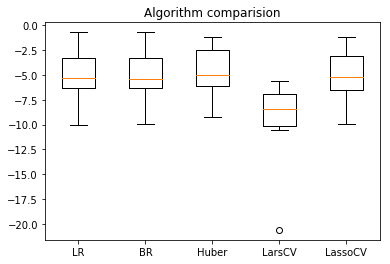

In [25]:
plt.figure(figsize=(13, 8))
fig, ax = plt.subplots()

ax.boxplot(results[:,1])
ax.set_xticklabels(results[:,0])
ax.set_title('Algorithm comparision')

plt.show()

Best performing model HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)


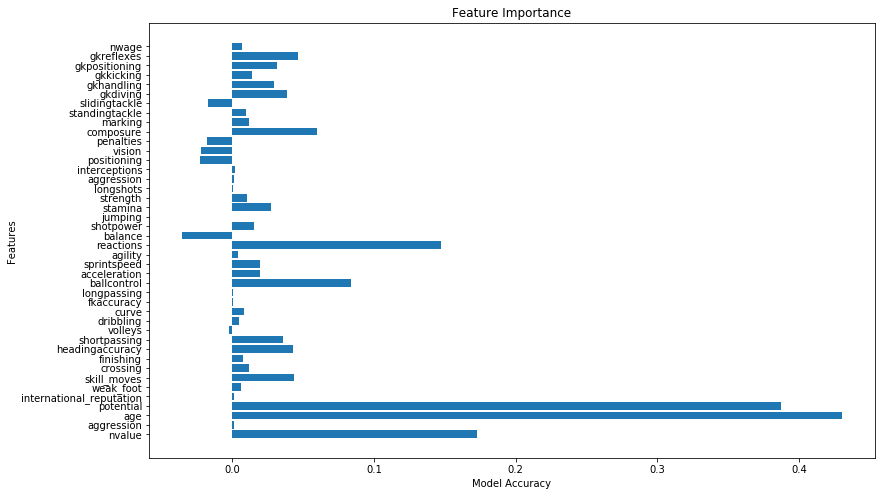

In [26]:
rf = np.array(models)[5:,1]
fi = imodel.fit(X, y).coef_
pos = np.arange(len(X.columns))
print("Best performing model", imodel)
plt.figure(figsize=(13, 8))
plt.barh(pos, fi)
plt.title("Feature Importance")
plt.xlabel("Model Accuracy")
plt.ylabel("Features")
plt.yticks(pos, (list(X)))
plt.show()